# Moving from standard to stream learning

This tutorial is inspired by the [river library](https://riverml.xyz) examples and recipes provided on their website.   Thus, we encourage the student to consult the original documentation for a more in-depth discussion of each of the particular topics.

In general,  nearly any approach in machine learning can be summarize in the following steps:

1. Defining the problem
   1. Identify the kind of problem (supervised vs unsupervised, classification vs regression, etc.)
2. Loading the data
3. Preprocessing that data
    1. Feature extraction
    2. Feature selection
4. Fitting the model
    1. Adjust the hyperparameters
5. Evaluate the model according certain measures

Before starting, let's examine a classical example that uses all these steps by  **using the scikit-learn library**:


In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from rich import print


# Load the data
dataset = load_breast_cancer()
X, y = dataset.data, dataset.target

# Prepare the pipeline with the preprocessing steps and the model to be used
pipe = Pipeline([
    ('scale', StandardScaler()),                       # Prepapare the data centered in avg 0 and std 1
    ('extractor', PCA(0.95)),                          # Extract features that represents 0.95 of the variability
    ('classifier', LogisticRegression(solver='lbfgs')) # Last step the model to perform the classificaction
])

# Define a determistic cross-validation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Calculate the performance for each fold of the cross validation
scorer = make_scorer(roc_auc_score)
scores = cross_val_score(pipe, X, y, scoring=scorer, cv=cv)

# Display the average score and it's standard deviation
print(f'ROC AUC: {scores.mean():.4f} (± {scores.std():.4f})')

ROC AUC: 0.9776 (± 0.0165)

So, what is the problem with this approach?  In reality, it has no problem,  but there are some potential disadvantages, particularly with respect to data size, addition of new data, and heterogeneity of features over time. 

Dataset  size:   Given the example above, imagine if the data returned by `load_breast_cancer` was too large to fit into the memory of your computer.  In that case,  the program would have crashed. Although some techniques can be applied to minimize this threat, such as optimizing the typing, or the use of sparse data storage,  there is a limit to the optimizations available.   Indeed, if the dataset consisted of millions of samples (corresponding to hundreds of gigabytes), special hardware may have been required just to load the dataset. One solution is to perform out-of-core learning,  which  works on data chunks or mini-batches;  potentially giving rise to other downstream effects related to the data ordering and spurious local minima of each mini-batch when using optimization to obtain model weights.   

Growing dataset:   Another potential issue is the incorporation of new data into the model. Traditional approaches require starting from scratch with a new dataset result of the combination of the old data with the new samples available. This is particularly problematic in real-time applications where you have new data available now and then. In many real applications, the solution is to perform a continuous integration pipeline which can deploy a new model nearly several times per minute.

Feature heterogeneity:   Finally, another disadvantage with this traditional ML approach is the availability of the features across time and/or datasets from different sources. In particular,  some features might not be available at a particular moment in time, but later become available with a new measurement system.  Another example is in a warehouse.  Imagine that at a particular moment,  the state or amount of an item in stock in the warehouse is not available until a later time (a month later, for example)  when it is included in the dataset.   

# Incremental learning

As mentioned before,  incremental learning is also referred to as online learning or stream learning.  The term “online” has been superseded by incremental or stream because of its confusion with vernacular usage of “online learning”, which more often refers to an education option  (this is obvious if you google "online learning"). Consequently, the terms "incremental learning" and "stream learning" are now preferred. 

The idea of incremental learning is now clear from our previous discussion:  it is concerned with fitting a ML model to a data stream.  Expressed differently,  the data isn't available in its entirety, but rather the observational samples are provided one by one. For example, imagine the previous classical example which, instead of the data set, we have a temporal reference point providing one sample at a time. This can be simulated with a simple loop, such as:


In [2]:
for xi, yi in zip(X, y):
    pass


Since the data is already in memory, this is not the ideal scenario to exemplify it. However, keep in mind that in this particular case we have access to a single sample at a single time (within the loop and represented by the scalar values xi, yi).  In effect, this loop simulates the data stream, where the zip returns a Python generator.   Note, that this is no different from the way we could iterate through a CSV file, receive a Kafka stream, or obtain the results of an SQL query, row by row.

One particular point to be aware of is the fact that in this example `xi` is an instance of `numpy.array` (data were loaded using scikit-learn library). By its design, the library that we are using for streaming learning, `river`, uses the class `dict` as the base of its behavior. The authors of the library assume a point of view where each observation represents a single sample,  which could make sense from the point of view of a stream of data. 

There are a few considerations that are worth noting:  
1. While the use of numpy is not a limitation,  it must be taken into consideration when  high performance (low-latency) is a system requirement.  Remember that `dict` is implemented in **Python**, while the `numpy.array` is implemented at a low level in **C** and **Fortran**. One of the advantages of using `dict` is easy access to the features and a clearer program. 

2. It must be also noted that  **online processing is different to batch processing, in that vectorization doesn't bring any speedup**. However numeric processing libraries such as numpy are optimized for vectorized operations, thereby introducing considerable overhead for the single sample processing.


In [3]:
print(f"In numpy.array format:{xi}\n")
print(f"In dict format: {dict(zip(dataset.feature_names, xi))}")

In numpy.array format:[7.760e+00 2.454e+01 4.792e+01 1.810e+02 5.263e-02 4.362e-02 0.000e+00
 0.000e+00 1.587e-01 5.884e-02 3.857e-01 1.428e+00 2.548e+00 1.915e+01
 7.189e-03 4.660e-03 0.000e+00 0.000e+00 2.676e-02 2.783e-03 9.456e+00
 3.037e+01 5.916e+01 2.686e+02 8.996e-02 6.444e-02 0.000e+00 0.000e+00
 2.871e-01 7.039e-02]

In dict format: {'mean radius': 7.76, 'mean texture': 24.54, 'mean perimeter': 47.92, 'mean area': 181.0, 'mean 
smoothness': 0.05263, 'mean compactness': 0.04362, 'mean concavity': 0.0, 'mean concave points': 0.0, 'mean 
symmetry': 0.1587, 'mean fractal dimension': 0.05884, 'radius error': 0.3857, 'texture error': 1.428, 'perimeter 
error': 2.548, 'area error': 19.15, 'smoothness error': 0.007189, 'compactness error': 0.00466, 'concavity error': 
0.0, 'concave points error': 0.0, 'symmetry error': 0.02676, 'fractal dimension error': 0.002783, 'worst radius': 
9.456, 'worst texture': 30.37, 'worst perimeter': 59.16, 'worst area': 268.6, 'worst smoothness': 0.08996, 'worst 
compactness': 0.06444, 'worst concavity': 0.0, 'worst concave points': 0.0, 'worst symmetry': 0.2871, 'worst 
fractal dimension': 0.07039}

For portability to existing ML algorithms and workflows, `river` provides a convenient wrapper function that transforms the datasets from `scikit-learn`to the required format. For the examples developed in this notebook, you can use the following

In [4]:
from river import stream
for xi, yi in stream.iter_sklearn_dataset(load_breast_cancer()):
    pass

While many operations translate quite easily between traditional ML and incremental learning,  some care must be taken when converting between the well-known batches and streams.   We shall illustrate this by considering  the problem of scaling data.   Recall that  the standardization of the data, i.e. scaling the data to have mean 0 and variance 1,  is a trivial operation over batches, while for data streams shall require running or moving statistics.   

This simple operation in the batched approach becomes slightly more complicated in the stream data because we don't know the values of the mean and the standard deviation before actually going through all the data. 

For data streams, a possible approach is to perform the first pass over the data to compute the necessary values and then scale the values during a second pass. However, this potential solution is inconsistent with our objective, and the characteristics of the data:   to process the data once. 

The solution to this is to use running statistics or moving statistics. The method consists in not using the exact mean and standard deviation,  but rather an estimation that is updated with each new value.   More formally,  given the mean, $\mu_t$,  and the element count  $n_t$, both at time $t$,  the mean can be easily updated at any moment by applying the following function:
$$\large
  n_{t+1} = n_t +1 \\    
  \large
  \mu_{t+1} = \mu_t +\frac{x - \mu_t}{n_{t+1}}    
$$


In the same way, for the variance ($\sigma$), the previous formula can be completed with:
$$
\large
  s_{t+1} = s_t + (x-\mu_t)\times(x-\mu_{t+1})\\
  \large
  \sigma_{t+1} = \frac{s_{t+1}}{n_{t+1}}
$$

where $s_t$  is a running sum of squares and $\sigma_t$ is the running variance at time $t$. These four formulae can be easily rewritten in Python for example, take the `mean radius` as our Guinea Pig:

In [7]:
#Let's inicialize the variables before any rolling calculation
n, mean, s, variance = 0, 0, 0, 0

for xi, yi in stream.iter_sklearn_dataset(load_breast_cancer()):
    n += 1
    mean_t = mean
    mean += (xi['mean radius'] - mean_t) / n
    s += (xi['mean radius'] - mean_t) * (xi['mean radius'] - mean)
    variance = s / n

    # print(f'Running mean: {mean:.3f} - Running variance: {variance:.3f}')
    
print(f'Mean: {mean:.3f} - Variance: {variance:.3f}')

Mean: 14.127 - Variance: 12.397

Now, compare the results with the ones implementations of `numpy`. 

In [6]:
import numpy as np
i = list(dataset.feature_names).index('mean radius')
print(f'True mean: {np.mean(X[:, i]):.3f}')
print(f'True variance: {np.var(X[:, i]):.3f}')

True mean: 14.127

True variance: 12.397

As expected,  the final results (at time $t$ and with the same $n_t$)  are identical with a key difference that  the `numpy` implementation requires that all data is available for the calculation while in the online case, it is calculated progressively.  Therefore, we should be cognizant of these ideas and realize that the results with only a few instances are not accurate. 


Although most of the running statistical measurements can be easily developed in Python, the reality is that it is not necessary, since River provides most of them in the `stats` module. For example, to create both the running mean and the running variance we can perform:

In [10]:
from river import stats

r_mean=stats.Mean()
r_variance=stats.Var()

for xi, yi in stream.iter_sklearn_dataset(load_breast_cancer()): 
    r_mean.update(xi['mean radius'])
    r_variance.update(xi['mean radius'])
    # print(f'Running mean: {r_mean.get():.3f} - Running variance: {r_variance.get():.3f}')
print(f'Running mean: {r_mean.get():.3f} - Running variance: {r_variance.get():.3f}')

Running mean: 14.127 - Running variance: 12.419

Thus, once we can calculate the different statistics on the data, the next step is to use those in order to normalize or standardize the data in a similar way as the batched approach. In `River`, several functions have been implemented for these operations and are available in the  `preprocessing` module. For example, to standardize all the features of the previous example we can perform:

In [22]:
from river.preprocessing import StandardScaler

scaler = StandardScaler()

for xi, yi in stream.iter_sklearn_dataset(load_breast_cancer()):
    scaler.learn_one(xi)

print(scaler.means, scaler.vars)

defaultdict(<class 'float'>, {
    'mean radius': 14.127291739894547,
    'mean texture': 19.289648506151124,
    'mean perimeter': 91.96903339191556,
    'mean area': 654.8891036906859,
    'mean smoothness': 0.09636028119507913,
    'mean compactness': 0.10434098418277679,
    'mean concavity': 0.08879931581722318,
    'mean concave points': 0.048919145869947306,
    'mean symmetry': 0.18116186291739875,
    'mean fractal dimension': 0.06279760984182786,
    'radius error': 0.4051720562390154,
    'texture error': 1.216853427065028,
    'perimeter error': 2.8660592267135288,
    'area error': 40.337079086115935,
    'smoothness error': 0.007040978910369068,
    'compactness error': 0.025478138840070295,
    'concavity error': 0.03189371634446398,
    'concave points error': 0.011796137082601056,
    'symmetry error': 0.02054229876977155,
    'fractal dimension error': 0.003794903866432336,
    'worst radius': 16.269189806678376,
    'worst texture': 25.677223198594042,
    'worst perimeter': 107.26121265377856,
    'worst area': 880.5831282952548,
    'worst smoothness': 0.13236859402460452,
    'worst compactness': 0.2542650439367314,
    'worst concavity': 0.27218848330404194,
    'worst concave points': 0.11460622319859404,
    'worst symmetry': 0.2900755711775047,
    'worst fractal dimension': 0.08394581722319859
})
defaultdict(<class 'float'>, {
    'mean radius': 12.397094259351807,
    'mean texture': 18.466397415995147,
    'mean perimeter': 589.4027985384283,
    'mean area': 123625.9030798645,
    'mean smoothness': 0.00019745207338314375,
    'mean compactness': 0.002784285489365303,
    'mean concavity': 0.006344078747698304,
    'mean concave points': 0.0015030146166694085,
    'mean symmetry': 0.0007502220077773413,
    'mean fractal dimension': 4.97611152010279e-05,
    'radius error': 0.07676719835798622,
    'texture error': 0.3037811231560936,
    'perimeter error': 4.080711486492195,
    'area error': 2065.7946205086837,
    'smoothness error': 8.999270217481403e-06,
    'compactness error': 0.0003201392613005828,
    'concavity error': 0.0009095968349446716,
    'concave points error': 3.8005508023387646e-05,
    'symmetry error': 6.821280528507752e-05,
    'fractal dimension error': 6.989386305292602e-06,
    'worst radius': 23.31916929965006,
    'worst texture': 37.71009176213321,
    'worst perimeter': 1127.1464342060979,
    'worst area': 323597.6708928499,
    'worst smoothness': 0.0005204036289546918,
    'worst compactness': 0.024711264995472597,
    'worst concavity': 0.04344759820889296,
    'worst concave points': 0.0043131471102436795,
    'worst symmetry': 0.0038208566791553046,
    'worst fractal dimension': 0.000325636075298754
})

### Applying Machine Learning

So, now that the data is scaled,  a machine learning algorithm can be implemented. This example employs linear regression based on *stochastic gradient descent (SGD)*.  The method works by optimizing the internal weights of the model with a loss function that minimizes the variance of the error made between prediction and the true output. In this particular case, the *Squared Error* is chosen as the form of the loss function in order to elude possible compensations due to signal change.

In [24]:
from river.linear_model import LogisticRegression
from river.optim import SGD

scaler = StandardScaler()
optimizer = SGD(lr=0.01)
log_reg = LogisticRegression(optimizer)

y_true = []
y_pred = []

for xi, yi in stream.iter_sklearn_dataset(load_breast_cancer(), shuffle=True, seed=42):

    # Scale the features
    scaler.learn_one(xi)
    xi_scaled = scaler.transform_one(xi)

    # Test the current model on the new "unobserved" sample
    yi_pred = log_reg.predict_proba_one(xi_scaled)
    # Train the model with the new sample
    log_reg.learn_one(xi_scaled, yi)

    # Store the truth and the prediction
    y_true.append(yi)
    y_pred.append(yi_pred[True])

print(f'ROC AUC: {roc_auc_score(y_true, y_pred):.4f}')

ROC AUC: 0.9896

The results seem to be slightly better than that obtained from  `scikit-learn`. However, let's make a proper comparison.

To make an equal comparison, each should use the same CV folds values.   Although we could define the same process quite easily, the two can be made completely comparable by using a built-in `river` module called `compat`.   This module is a wrapper that improves the compatibility with other Python libraries such as sklearn.   This can be done by calling the function  `convert_river_to_sklearn` to obtain an object perfectly compatible with the functions of `scikit-learn`.


In [25]:
from river.compose import Pipeline
from river.compat import convert_river_to_sklearn


# We define a Pipeline, becasuse we need a single object 
model = Pipeline(
    ('scale', StandardScaler()),
    ('ml_model', LogisticRegression())
)

# This funtion returns an object of type SKLRegressorWrapper 
# which is compatible with the signature of sklearn
model = convert_river_to_sklearn(model)

# Now, we can proceed using the cross_val_score from 
# sklearn with the River wrapped model
scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)

# Let's compare the results
print(f'ROC AUC: {scores.mean():.4f} (± {scores.std():.4f})')

ROC AUC: 0.9639 (± 0.0158)

Although they are lower than the previous test, the results are comparable to the batch learning approach. 

# Pipelines

Although briefly introduced in the introduction section, the "flow" of information in a machine learning approach can often be encapsulated as a sequence of steps. For this, some standard libraries such as `scikit-learn` or `pandas` provide objects that implement this “declarative” pattern.    River has a special set of modules for implementing pipelines for stream learning. 

In practice, pipelines are not often used by developers for representing their workflows.  The main reason for this is that most developers come from the world of traditional “batch” oriented ML, where procedural programming is used.   However, in stream learning, pipelines represent a more natural way to map the problem to the programming idiom. 

In the next example,  we shall compare both the procedural and pipeline-based declarative methods with the same problem.   For this, we shall use a problem from one of the Kaggle competitions. 


In [26]:
from rich import print
from river.datasets import Restaurants

data = Restaurants()

print(data)

Data from the Kaggle Recruit Restaurants challenge.

The goal is to predict the number of visitors in each of 829 Japanese restaurants over a priod
of roughly 16 weeks. The data is ordered by date and then by restaurant ID.

      Name  Restaurants                                                               
      Task  Regression                                                                
   Samples  252,108                                                                   
  Features  7                                                                         
    Sparse  False                                                                     
      Path  /Users/alexdopico/river_data/Restaurants/kaggle_recruit_restaurants.csv   
       URL  https://maxhalford.github.io/files/datasets/kaggle_recruit_restaurants.zip
      Size  27.54 MB                                                                  
Downloaded  False

Lets check the structure of the data:

In [30]:
print(next(iter(data)))

Uncompressing into /Users/alexdopico/river_data/Restaurants


(
    {
        'store_id': 'air_04341b588bde96cd',
        'date': datetime.datetime(2016, 1, 1, 0, 0),
        'is_holiday': True,
        'genre_name': 'Izakaya',
        'area_name': 'Tōkyō-to Nerima-ku Toyotamakita',
        'latitude': 35.7356234,
        'longitude': 139.6516577
    },
    10
)

###  Procedural Approach: 

First, lets start by writing the ML analysis code with the procedural approach 

In [32]:
from river import feature_extraction, linear_model, metrics, preprocessing, stats, utils

# Let's create the average of the last 7, 14 and 21 days
#TargetAgg: Computes a streaming aggregate of the target values
features = (
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 7),target_name="last_7_mean"),
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 14),target_name="last_14_mean"),
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 21),target_name="last_21_mean")
)

scaler = preprocessing.StandardScaler()
model = linear_model.LinearRegression()
metric = metrics.MAE()

for x, y in data:

    # Derive date features
    x['weekday'] = x['date'].weekday()
    x['is_weekend'] = x['date'].weekday() in (5, 6)

    # Process the rolling means of the target  
    for mean_f in features:
        
        x = {**x, **mean_f.transform_one(x)}#** unzip a dictionary. In this way, it is concatenating two dicts   
        mean_f.learn_one(x, y)
   
    # Remove the key/value pairs that aren't features
    for key in ['store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude']:
        x.pop(key)

    # Rescale the data
    scaler.learn_one(x)
    x = scaler.transform_one(x)
    # Fit the linear regression
    y_pred = model.predict_one(x)
    model.learn_one(x, y)

    # Update the metric using the out-of-fold prediction
    metric.update(y, y_pred)

print(metric)

MAE: 8.465114

In [33]:
#check the last sample
print(x)

{
    'is_holiday': -0.23103573677646685,
    'weekday': 1.0292832579142892,
    'is_weekend': 1.6249280076334165,
    'last_7_mean_mean_by_store_id': -1.350231449980909,
    'last_14_mean_mean_by_store_id': -1.4125913815779152,
    'last_21_mean_mean_by_store_id': -1.3980979075298516
}

###  Declaritive approach using River Pipelines

Now, lets rewrite the same code but this time using the declarative approach using River Pipelines.


In [34]:
from river import compose

# funtion to transform the data in the same features used previously
def get_date_features(x):
    weekday =  x['date'].weekday()
    return {'weekday': weekday, 'is_weekend': weekday in (5, 6)}

# Build the pipeline with the same steps that has been previously done
model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('date_features', compose.FuncTransformer(get_date_features)),
        ('last_7_mean', feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(),7),target_name="last_7_mean")),
        ('last_14_mean', feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(),14), target_name="last_14_mean")),
        ('last_21_mean', feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(),21), target_name="last_21_mean"))
    )),
    ('drop_non_features', compose.Discard('store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude')),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression())
)

metric = metrics.MAE()

for x, y in data:

    # Make a prediction without using the target
    y_pred = model.predict_one(x)

    # Update the model using the target
    model.learn_one(x, y)

    # Update the metric using the out-of-fold prediction
    metric.update(y, y_pred)

print(x)
print(metric)


{
    'store_id': 'air_fff68b929994bfbd',
    'date': datetime.datetime(2017, 4, 22, 0, 0),
    'is_holiday': False,
    'genre_name': 'Bar/Cocktail',
    'area_name': 'Tōkyō-to Nakano-ku Nakano',
    'latitude': 35.7081457,
    'longitude': 139.66628799999998
}

MAE: 8.385425

As can be seen,  we have arranged all the feature calculations and transformations  into the object `TransformerUnion`, which groups multiple feature processing steps together into a single transformer. This allows for easy combination and management of multiple feature processing steps in a machine learning pipeline. The TransformerUnion object takes a list of transformers as input and applies them in sequence to the input data.

Additionally, the `for-loop` is a common operation in an online learning system, and therefore provided as a built-in evaluation function. 


In [35]:
from river import evaluate

model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('date_features', compose.FuncTransformer(get_date_features)),
        ('last_7_mean', feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 7),target_name="last_7_mean" )),
        ('last_14_mean', feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 14),target_name="last_14_mean")),
        ('last_21_mean', feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 21),target_name="last_21_mean"))
    )),
    ('drop_non_features', compose.Discard('store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude')),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression())
)

evaluate.progressive_val_score(dataset=data, model=model, metric=metrics.MAE())

MAE: 8.385425

Although the code is correct, some additional simplifications can be implemented. Unlike the idiomatic structure of  pipelines in `scikit-learn`, the name of the steps is not necessary.

In [36]:
model = compose.Pipeline(
    compose.TransformerUnion(
        compose.FuncTransformer(get_date_features),
        feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 7),target_name="last_7_mean"),
        feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 14),target_name="last_14_mean"),
        feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 21),target_name="last_21_mean")
    ),
    compose.Discard('store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude'),
    preprocessing.StandardScaler(),
    linear_model.LinearRegression()
)

evaluate.progressive_val_score(dataset=data, model=model, metric=metrics.MAE())


MAE: 8.385425

In this case the library will infer one based on the order of the operations provided.

The next simplification comes from the fact that the pipeline can be declared with mathematical operations. First, use `+` to declare a `TransformerUnion` object.


In [37]:
model = compose.Pipeline(
    compose.FuncTransformer(get_date_features) + \
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 7),target_name="last_7_mean") + \
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 14),target_name="last_14_mean") + \
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 21),target_name="last_21_mean"),

    compose.Discard('store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude'),
    preprocessing.StandardScaler(),
    linear_model.LinearRegression()
)

evaluate.progressive_val_score(dataset=data, model=model, metric=metrics.MAE())


MAE: 8.385425

Likewhise we can use the `|` operator to assemble steps into a `Pipeline`.

In [38]:
model = (
    compose.FuncTransformer(get_date_features) +
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 7),target_name="last_7_mean") +
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 14),target_name="last_14_mean") +
    feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), 21),target_name="last_21_mean")
)

to_discard = ['store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude']

model = model | compose.Discard(*to_discard)
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression()

evaluate.progressive_val_score(dataset=data, model=model, metric=metrics.MAE())


MAE: 8.385425

One final simplyfication comes from the fact that `river`automatically encapsulates functions in the `FuncTransform` so the final declarative model could be something like:

In [39]:
model = get_date_features

for n in [7, 14, 21]:
    model += feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), n),target_name="last_"+str(n)+"_mean")

model |= compose.Discard(*to_discard)
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression()

evaluate.progressive_val_score(dataset=data, model=model, metric=metrics.MAE(), print_every=20_000)

[20,000] MAE: 8.752951
[40,000] MAE: 8.905924
[60,000] MAE: 8.928998
[80,000] MAE: 8.649261
[100,000] MAE: 8.491545
[120,000] MAE: 8.422006
[140,000] MAE: 8.347251
[160,000] MAE: 8.33218
[180,000] MAE: 8.44191
[200,000] MAE: 8.359173
[220,000] MAE: 8.316521
[240,000] MAE: 8.369277
[252,108] MAE: 8.385425


MAE: 8.385425

We have included an additional argument to print how the evaluation changes over time. 

The use of procedural or declarative does not affect the overall performance,  but rather the way we think about the model.  In fact, both models, either procedural or declarative,  will produce the same results and performance.   

As final point in the pipelines, it should be mentioned that we can explore graphically the pipeline when it is made based on pipes


In [40]:
model

Pipeline (
  TransformerUnion (
    FuncTransformer (
      func="get_date_features"
    ),
    TargetAgg (
      by=['store_id']
      how=Rolling (
        obj=Mean ()
        window_size=7
      )
      target_name="last_7_mean"
    ),
    TargetAgg (
      by=['store_id']
      how=Rolling (
        obj=Mean ()
        window_size=14
      )
      target_name="last_14_mean"
    ),
    TargetAgg (
      by=['store_id']
      how=Rolling (
        obj=Mean ()
        window_size=21
      )
      target_name="last_21_mean"
    )
  ),
  Discard (
    area_name
    date
    genre_name
    latitude
    longitude
    store_id
  ),
  StandardScaler (
    with_std=True
  ),
  LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

Finally,  to debug the behavior of the different steps the function `debug_one`can be used. Imagine that, in this case we train the model with the first 120,000 examples and we want to know what happens with the following one. The next piece of code shows how to use the function `debug_one`.

In [41]:
import itertools

model = get_date_features

for n in [7, 14, 21]:
    model += feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), n),target_name="last_"+str(n)+"_mean")


model |= compose.Discard(*to_discard)
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression()

for x, y in itertools.islice(data, 120_000):
    y_pred = model.predict_one(x)
    model.learn_one(x, y)

x, y = next(iter(data))
print(model.debug_one(x))

0. Input
--------
area_name: Tōkyō-to Nerima-ku Toyotamakita (str)
date: 2016-01-01 00:00:00 (datetime)
genre_name: Izakaya (str)
is_holiday: True (bool)
latitude: 35.73562 (float)
longitude: 139.65166 (float)
store_id: air_04341b588bde96cd (str)

1. Transformer union
--------------------
    1.0 get_date_features
    ---------------------
    is_weekend: False (bool)
    weekday: 4 (int)

    1.1 TargetAgg
    -------------
    last_7_mean_mean_by_store_id: 36.28571 (float)

    1.2 TargetAgg1
    --------------
    last_14_mean_mean_by_store_id: 36.07143 (float)

    1.3 TargetAgg2
    --------------
    last_21_mean_mean_by_store_id: 36.23810 (float)

is_weekend: False (bool)
last_14_mean_mean_by_store_id: 36.07143 (float)
last_21_mean_mean_by_store_id: 36.23810 (float)
last_7_mean_mean_by_store_id: 36.28571 (float)
weekday: 4 (int)

2. ~['area_name', 'date', 'genre_name', 'latitude', 'longitude', 'store_id']
----------------------------------------------------------------------------
is_weekend: False (bool)
last_14_mean_mean_by_store_id: 36.07143 (float)
last_21_mean_mean_by_store_id: 36.23810 (float)
last_7_mean_mean_by_store_id: 36.28571 (float)
weekday: 4 (int)

3. StandardScaler
-----------------
is_weekend: -0.61171 (float)
last_14_mean_mean_by_store_id: 1.30097 (float)
last_21_mean_mean_by_store_id: 1.32644 (float)
last_7_mean_mean_by_store_id: 1.28498 (float)
weekday: 0.51168 (float)

4. LinearRegression
-------------------
Name                            Value      Weight      Contribution  
                    Intercept    1.00000    18.99682       18.99682  
last_21_mean_mean_by_store_id    1.32644     9.48096       12.57591  
last_14_mean_mean_by_store_id    1.30097     2.72577        3.54615  
                      weekday    0.51168     5.61055        2.87078  
 last_7_mean_mean_by_store_id    1.28498     1.23553        1.58763  
                   is_weekend   -0.61171    -1.96213        1.20026  

Prediction: 40.77756

# The incremental learning with decision trees

Until this point we have focussed on ML techniques that can be implemented in a seamless way with incremental learning, such as the linear or logistic regression. However, there are other techniques that can be adapted to follow this approach, although they require more effort. 


For example, decision Trees and their variants are an important family of ML techniques.  These methods have proven particularly useful and performant when used in conjunction with ensemble techniques  (bagging, boosting, etc.).  The often cited advantages of decision trees are their flexibility, versatility towards data, and simplicity to implement. 

Nonetheless,  traditional decision tree algorithms require several iterations over the data, thereby rendering them unsuitable for incremental (stream) learning.   As such,  several candidate tree algorithms have emerged that address this issue and make them suitable for stream learning.  


One of the most popular adaptations is Hoeffding Trees (HT) due to their properties similar to batched approaches, such as (C4.5/J48, CART, M5, etc.):
* Only require a single pass over the data
* (Theoretical) guarantees the convergence with their batch counterpart with enough observations and a stationary data distribution
* It can operate on scarce resources of memory and computation time.
* Some of their variations can deal with non-stationary distributions


In fact,  with the recent spotlight on  Explainable Artificial Intelligence (XAI),  these tree  techniques have taken on a special importance,  because they offer better interpretation.

To explore the use of these tree algorithms,  we shall study a simple example where its use can be representative. For this,  we will use the same Restaurant dataset,  downloaded previously, however now analyzed with a single tree. 


In [43]:
%%time

from river import evaluate, metrics, stats, utils, feature_extraction, preprocessing, compose
from river.tree import HoeffdingTreeRegressor
import itertools

data = Restaurants()
to_discard = ['store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude']
def get_date_features(x):
    weekday =  x['date'].weekday()
    return {'weekday': weekday, 'is_weekend': weekday in (5, 6)}

model = get_date_features

for n in [7, 14, 21]:
    model += feature_extraction.TargetAgg(by='store_id', how=utils.Rolling(stats.Mean(), n),target_name="last_"+str(n)+"_mean")

model |= compose.Discard(*to_discard)
model |= preprocessing.StandardScaler()
model |= HoeffdingTreeRegressor(grace_period=250) #Number of instances a leaf should observe between split attempts

for x, y in data:
    model.learn_one(x, y)


CPU times: user 17.4 s, sys: 61.2 ms, total: 17.5 s
Wall time: 17.6 s


From this point,  we can now analyze the resulting model in different ways.

In [44]:
#object analysing
model['HoeffdingTreeRegressor']

HoeffdingTreeRegressor (
  grace_period=250
  max_depth=inf
  delta=1e-07
  tau=0.05
  leaf_prediction="adaptive"
  leaf_model=LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
  model_selector_decay=0.95
  nominal_attributes=None
  splitter=TEBSTSplitter (
    digits=1
  )
  min_samples_split=5
  binary_split=False
  max_size=500.
  memory_estimate_period=1000000
  stop_mem_management=False
  remove_poor_attrs=False
  merit_preprune=True
)

That gives an idea of the internal parameters of the object, although we can ask for a summary

In [45]:
#summary of the tree
model['HoeffdingTreeRegressor'].summary

{'n_nodes': 1089,
 'n_branches': 544,
 'n_leaves': 545,
 'n_active_leaves': 545,
 'n_inactive_leaves': 0,
 'height': 29,
 'total_observed_weight': 252108.0}

In [46]:
#Pandas data frame 
(model['HoeffdingTreeRegressor']).to_dataframe()

,parent,is_leaf,depth,stats,feature,threshold,splitter,splitters,_disabled_attrs,_last_split_attempt_at,_leaf_model,_model_supports_weights,_fmse_mean,_fmse_model
node,,,,,,,,,,,,,,
0,<NA>,False,0,Var: 327.461181,last_14_mean_mean_by_store_id,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,False,1,Var: 181.847278,last_14_mean_mean_by_store_id,-0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,False,1,Var: 418.16041,last_7_mean_mean_by_store_id,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,False,2,Var: 58.15876,last_21_mean_mean_by_store_id,-0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,False,2,Var: 269.56242,last_21_mean_mean_by_store_id,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,1078,False,27,Var: 207.17208,last_14_mean_mean_by_store_id,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1085,1082,True,28,Var: 247.713049,NaN,NaN,TEBSTSplitter,{},{},157.0,LinearRegression,True,5132.012782,5241.861165
1086,1082,True,28,Var: 189.247257,NaN,NaN,TEBSTSplitter,{'last_21_mean_mean_by_store_id': TEBSTSplitte...,{},823.0,LinearRegression,True,4145.609909,3916.406135


This last command could be interesting in a classification approach due to the ability to analyze the internal decision of the model and check the thresholds and weights given,   while  in a regression model it is not useful.  Thus,  lets see an example in the context of classification


In [47]:

from river import evaluate, metrics, stats, utils, feature_extraction, preprocessing, compose
from river.tree import HoeffdingTreeClassifier
from river.datasets import Phishing #
import itertools

data = Phishing()

model = HoeffdingTreeClassifier(grace_period=50)

for x, y in data:
    model.learn_one(x, y)
    
    
#summary of the tree
print(model.summary)
    
model.to_dataframe()

{
    'n_nodes': 5,
    'n_branches': 2,
    'n_leaves': 3,
    'n_active_leaves': 3,
    'n_inactive_leaves': 0,
    'height': 3,
    'total_observed_weight': 1250.0
}

,parent,is_leaf,depth,stats,feature,threshold,splitter,splitters,_disabled_attrs,_last_split_attempt_at,_mc_correct_weight,_nb_correct_weight
node,,,,,,,,,,,,
0,<NA>,False,0,"{True: 260.0, False: 390.0}",empty_server_form_handler,0.545455,NaN,NaN,NaN,NaN,NaN,NaN
1,0,True,1,"{True: 443.4163997711022, False: 59.8769131081...",NaN,NaN,GaussianSplitter,{'empty_server_form_handler': GaussianSplitter...,{},474.293313,249.0,248.0
2,0,False,1,"{True: 71.58360022889781, False: 404.123086891...",popup_window,0.090909,NaN,NaN,NaN,NaN,NaN,NaN
3,2,True,2,"{False: 31.426538522574834, True: 33.0}",NaN,NaN,GaussianSplitter,{'empty_server_form_handler': GaussianSplitter...,{},59.426539,23.0,36.0
4,2,True,2,"{False: 250.57346147742516, True: 6.0}",NaN,NaN,GaussianSplitter,{'empty_server_form_handler': GaussianSplitter...,{},241.573461,210.0,196.0


As can be seen, the results are more useful than the output of the regression problem.  Also,  a feature that is useful for explainability is the plotting of the tree.

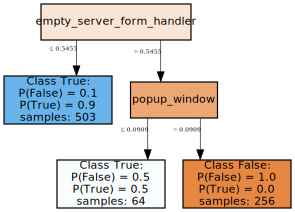

In [48]:
#plot like a tree
#be aware to have graphviz installed on the system
model.draw()

`River`has many implementations of the tree but as the authors of the library remember on their [page](https://riverml.xyz/0.14.0/recipes/on-hoeffding-trees/#1-trees-trees-everywhere-gardening-101-with-river), most of them can be organized in the following table.

| Name | Acronym | Task | Non-stationary data? | Comments | Source |
| :- | :-: | :- | :-: | :- | :-: |
| Hoeffding Tree Classifier | HTC | Classification | No | Basic HT for classification tasks | [[1]](https://dl.acm.org/doi/pdf/10.1145/347090.347107)
| Hoeffding Adaptive Tree Classifier | HATC | Classification | Yes | Modifies HTC by adding an instance of ADWIN to each node to detect and react to drift detection | [[2]](https://link.springer.com/chapter/10.1007/978-3-642-03915-7_22)
| Extremely Fast Decision Tree Classifier | EFDT | Classification | No | Deploys split decisions as soon as possible and periodically revisit decisions and redo them if necessary. Not as fast in practice as the name implies, but it tends to converge faster than HTC to the model generated by a batch DT | [[3]](https://dl.acm.org/doi/abs/10.1145/3219819.3220005)
| Hoeffding Tree Regressor | HTR | Regression | No | Basic HT for regression tasks. It is an adaptation of the [FIRT/FIMT](https://link.springer.com/article/10.1007/s10618-010-0201-y) algorithm that bears some semblance to HTC | [[4]](https://link.springer.com/article/10.1007/s10618-010-0201-y)
| Hoeffding Adaptive Tree Regressor | HATR | Regression | Yes | Modifies HTR by adding an instance of ADWIN to each node to detect and react to drift detection |
| incremental Structured-Output Prediction Tree Regressor| iSOUPT | Multi-target regression | No | Multi-target version of HTR | [[5]](https://link.springer.com/article/10.1007/s10844-017-0462-7)
| Label Combination Hoeffding Tree Classifier | LCHTC | Multi-label classification | No | Creates a numerical code for each combination of the binary labels and uses HTC to learn from this encoded representation. At prediction time, decodes the modified representation to obtain the original label set |  -


As we can see each variant has a very specific target in mind, although they might overlap sometimes.

# Suggested Exercises

1. To study incremental learning further, modify the above example that calculates the mean and variance to study data standardization with these methods: 
* To now calculate the running median and mode of the data. 
* Compare and contrast the results of the running median and mode to the running mean and variance, and observe how the different measures change as more data is added incrementally. 
* Explore other ways of normalizing the data, such as using the z-score or the min-max normalization method.


2.  After data normalization,  we provide an example that uses linear regression based on stochastic gradient descent (SGD) and a square loss.   
* Write the code that will use another  loss function and optimizer available in River.    
* Write the same code, but now wrapping the equivalent Scikit model.  How do the two compare?  



3. Trees and Incremental learning:  Modify the example above that uses the HoeffdingTreeRegressor.  To do this, experiment with different values for the grace_period parameter of the HoeffdingTreeRegressor.   The grace_period parameter controls the number of instances a leaf should observe between split attempts. Increasing the value of grace period will lead to fewer splits and thus a smaller tree.  In particular, try different values for grace_period (e.g. 50, 100, 250, 500) and see how it affects the size of the tree and the performance of the model. Write a code snippet that modifies the pipeline and runs the progressive evaluation. Evaluate the model using a evaluation metric of your choice.


In [79]:
from scipy import stats
#Let's inicialize the variables before any rolling calculation

def calculate_median_mode():
    median, mode, n = 0, 0, 0
    values = np.array([])

    for xi, _ in stream.iter_sklearn_dataset(load_breast_cancer()):
        n += 1
        index_to_insert = np.searchsorted(values, xi['mean radius'])
        values = np.insert(values, index_to_insert, xi['mean radius'])
        median = values[n//2]

        unique, count = np.unique(values, return_counts=True)
        mode = unique[np.argmax(count)]

        # print(f'Running median: {median:.3f} - Running variance: {variance:.3f}')
        
    print(f'Median: {median:.3f} - Mode: {mode:.3f}')
    print(f'Numpy Median: {np.median(values):.3f} - Scipy Mode: {stats.mode(values)[0]:.3f}')
    return median, mode

def calculate_min_max():
    min_value, max_value = np.inf, 0
    values = []
    for xi, _ in stream.iter_sklearn_dataset(load_breast_cancer()):
        
        if xi['mean radius'] < min_value:
            min_value = xi['mean radius']
        
        if xi['mean radius'] > max_value:
            max_value = xi['mean radius']
        
        values.append(xi['mean radius'])
        
    print(f'Min: {min_value:.3f} - Max: {max_value:.3f}')
    print(f'Python Min: {min(values):.3f} - Python Max: {max(values):.3f}')
    return min_value, max_value
